# Big Data Analysis: Weapons and Drugs

<pre>
In this Report, we will try to prove/analyze some claims using Big Data tools like Apache Spark and Python and visualization tools like Matplotlib.

-----------------------------------------------------------------------------------------------------------
</pre>

<pre>
Firstly, Importing all the necessary libraries needed for the analysis.
</pre>

In [9]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.types import *
from pyspark.sql import Window

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from matplotlib import pyplot as plt

<pre>
Creating a session to initialize Spark Session which will allow us to use all Spark Core related APIs. Making a function which will take <b>Application name</b> as an argument and will return a spark session variable with the appName as passed in argument
</pre>

In [2]:
def getSession(appName):
    ''' This function takes Application name as argument and returns spark session variable
    '''
    
    spark = SparkSession.builder.appName(appName).getOrCreate()
    
    return spark

<pre>
Initializing Spark Session using the function we created.
</pre>

In [3]:
spark = getSession("analysis")

<pre>
With all the initializations done, lets proceed to the main part of our report which is analyzing the claims made at <b>“Ross Kemp and the Armed Police” broadcast 6th September 2018 by ITV</b>.

There were three claims made:
1. Violent Crime is increasing
2. There are more firearms incidents per head in Birmingham than anywhere else in the UK
3. Crimes involving firearms are closely associated with drugs offences

Let us try to analyze each claim one by one.
</pre>

## Violent Crime is increasing

<pre>
To analyze this claim, we will need the crimes dataset, so let us read the crimes dataset initially.

Before that, lets understand briefly about the dataset we are reading. The crimes dataset is in csv format and contains data about reported and logged crimes from 2010-2017. The source of the dataset is given in reference<sup>[1]</sup>. The dataset contains details at month level and force level and have 11 columns in total. As per the website<sup>[2]</sup> the coordinates of the dataset is anonymized so it might not coincide with the postal codes dataset<sup>[3]</sup>, <b>for this reason LSOA (Lower Layer Super Output Area, UK Office for National Statistics) will be used as region indicator.</b>

</pre>

In [4]:
# Function to read any dataset from the location passed in argument

def read_data_from_csv(location, schema, delimiter=',', header=True):
    ''' This function reads data from csv file and returns the dataframe
    '''
    df = spark.read.format("csv") \
            .option("delimiter", delimiter) \
            .option("header", header) \
            .schema(schema) \
            .load(location)
    
    return df

In [5]:
# Creating a static schema for crimes data
crimes_schema = StructType(
                        [StructField("crime_id", StringType(), nullable=True),
                         StructField("month", StringType(),  nullable=True),
                         StructField("reported_by", StringType(), nullable=True),
                         StructField("falls_within", StringType(), nullable=True),
                         StructField("longitude", DoubleType(), nullable=True),
                         StructField("latitude", DoubleType(), nullable=True),
                         StructField("location", StringType(), nullable=True),
                         StructField("lsoa_code", StringType(), nullable=True),
                         StructField("lsoa_name", StringType(), nullable=True),
                         StructField("crime_type", StringType(), nullable=True),
                         StructField("last_outcome_category", StringType(), nullable=True),
                         StructField("context", StringType(), nullable=True)
                         ]
                    )

# Reading crimes dataset
crimes_df = read_data_from_csv("/home/hduser/work/nikhil/dataset/all_crimes18_hdr.txt.gz",
                               schema = crimes_schema)

<pre>
Checking the count of the dataset
</pre>

In [39]:
print("Count: ",crimes_df.count())

Count:  46986836


<pre>
Lets see some data from the dataset
</pre>

In [79]:
crimes_df.limit(10).toPandas().head(10)

,crime_id,month,reported_by,falls_within,longitude,latitude,location,lsoa_code,lsoa_name,crime_type,last_outcome_category,context
0,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,None,None
1,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
2,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
3,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
4,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
5,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
6,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.513308,51.409456,On or near Charlton Road,E01014399,Bath and North East Somerset 001A,Burglary,None,None
7,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St. Francis Road,E01014399,Bath and North East Somerset 001A,Burglary,None,None
8,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Other crime,None,None
9,None,2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.497767,51.420232,On or near Chandos Road,E01014400,Bath and North East Somerset 001B,Anti-social behaviour,None,None


<pre>
Lets check the years of data we have in our dataset
</pre>

In [80]:
# As year column is not present in dataset, extracting year information from month column
crimes_yearly_df = crimes_df.withColumn("year", fn.substring("month", 1, 4))
crimes_yearly_df.select("year").distinct().show()

+----+
|year|
+----+
|2016|
|2012|
|2017|
|2014|
|2013|
|2018|
|2011|
|2015|
|2010|
+----+



<pre>
Now, we will check the types of crime happening as per the dataset

</pre>

In [82]:
# False is argument is given so the data displayed wont by trimmed to certain characters

crimes_df.select("crime_type").distinct().show(50, False)

+----------------------------+
|crime_type                  |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
|Anti-social behaviour       |
+----------------------------+



<pre>
For our claim, we will need only violent crime types, so filtering out the relevant data
</pre>

In [89]:
violent_crimes_df = crimes_yearly_df.filter("crime_type in ('Public disorder and weapons',  \
                                             'Criminal damage and arson',  \
                                             'Violent crime','Possession of weapons', \
                                             'Violence and sexual offences')")

<pre>
Let us check the number of violent crimes per year and visualize the output data to check whether the violent crimes are increasing or decreasing
</pre>

In [92]:
violent_crimes_grouped = violent_crimes_df.groupBy("year").agg(fn.count("*").alias("violent_crimes_count"))\
                                          .orderBy("year")

In [93]:
violent_crimes_grouped.show(10, False)

+----+--------------------+
|year|violent_crimes_count|
+----+--------------------+
|2010|57580               |
|2011|988235              |
|2012|1387497             |
|2013|1271151             |
|2014|1377866             |
|2015|1623721             |
|2016|1843933             |
|2017|2163148             |
|2018|1380457             |
+----+--------------------+



<pre>
Let us visualize the data on a graph
</pre>

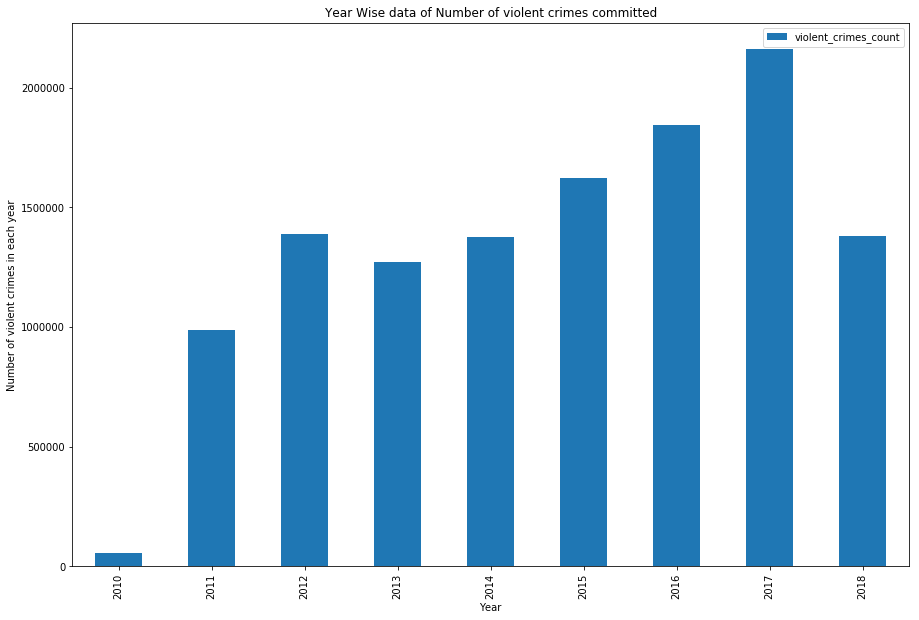

In [109]:
pd_violent_crimes_grouped = violent_crimes_grouped.toPandas()

pd_violent_crimes_grouped.plot(x="year", y="violent_crimes_count", kind="bar", figsize=(15, 10))

plt.title("Year Wise data of Number of violent crimes committed")
plt.xlabel("Year")
plt.ylabel("Number of violent crimes in each year")
plt.show()

<pre>
So, as we can see in the line graph, there is a stagnant increase in number of violent cases per year but there is steep drop from 2017-2018. But, as a whole number of violent cases are increasing per each year.

For further proof and analysis, lets check the increase or decrease in number of cases per each year for each type of violent crime.
</pre>

In [104]:
# Grouping the data by crime_type and year

violent_crimes_grouped2 = violent_crimes_df.groupBy("crime_type", "year") \
                                           .agg(fn.count("*").alias("violent_crimes_count")) \
                                           .orderBy("crime_type","year")

In [106]:
# Pivoting crime_type data to column to visualize the data

violent_crimes_pivot = violent_crimes_grouped2.groupBy("year") \
                                              .pivot("crime_type") \
                                              .agg(fn.sum("violent_crimes_count"))

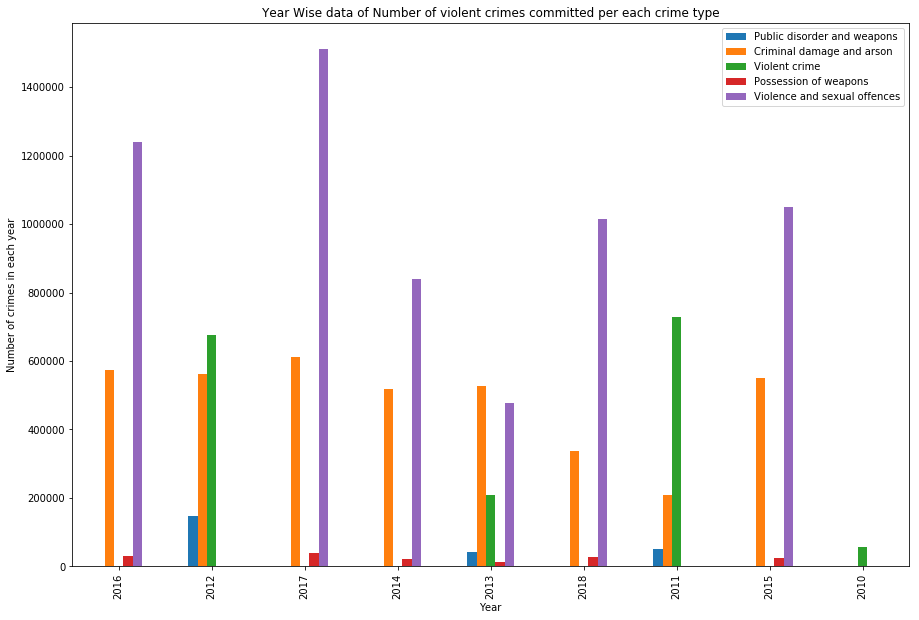

In [128]:
# Visualizing data on a graph

pd_violent_crimes_pivot = violent_crimes_pivot.na.fill(0).toPandas()

pd_violent_crimes_pivot.plot(x="year", 
                               y=['Public disorder and weapons',  
                                     'Criminal damage and arson',  
                                     'Violent crime','Possession of weapons', 
                                     'Violence and sexual offences'], 
                               kind="bar", figsize=(15, 10), style="o-")

plt.title("Year Wise data of Number of violent crimes committed per each crime type")
plt.xlabel("Year")
plt.ylabel("Number of crimes in each year")
plt.show()

<pre>
So, as per out analysis the number of violent cases are increasing with time so the claim made at the show holds true. Now, lets move on the analyze the second claim made at the show which was <b>There are more firearms incidents per head in Birmingham than anywhere else in the UK</b>.

## There are more firearms incidents per head in Birmingham than anywhere else in the UK

<pre>
To analyze the above claim, we will need the postal codes dataset<sup>[3]</sup>.

    Postal codes dataset contains data related to coordinates and area related details. It have more the 15 columns with most of the columns containing data related to geography. Important column for us is the LSOA code which we are going to use as location indicator as the coordinates in crime dataset are anonymized as per the source<sup>[2]</sup>

</pre>

In [6]:
# Declaring static schema for the dataset
postalcodes_schema = StructType(
                                [
                                    StructField("postcode", StringType(), nullable=True),
                                    StructField("inUse", StringType(), nullable=True),
                                    StructField("latitude", DoubleType(), nullable=True),
                                    StructField("longitude", DoubleType(), nullable=True),
                                    StructField("easting", IntegerType(), nullable=True),
                                    StructField("northing", IntegerType(), nullable=True),
                                    StructField("gridRef", StringType(), nullable=True),
                                    StructField("county", StringType(), nullable=True),
                                    StructField("district", StringType(), nullable=True),
                                    StructField("ward", StringType(), nullable=True),
                                    StructField("districtCode", StringType(), nullable=True),
                                    StructField("wardCode", StringType(), nullable=True),
                                    StructField("country", StringType(), nullable=True),
                                    StructField("countyCode", StringType(), nullable=True),
                                    StructField("constituency", StringType(), nullable=True),
                                    StructField("introduced", TimestampType(), nullable=True),
                                    StructField("terminated", TimestampType(), nullable=True),
                                    StructField("parish", StringType(), nullable=True),
                                    StructField("nationalPark", StringType(), nullable=True),
                                    StructField("population", IntegerType(), nullable=True),
                                    StructField("households", IntegerType(), nullable=True),
                                    StructField("builtUpArea", StringType(), nullable=True),
                                    StructField("builtupsubdivision", StringType(), nullable=True),
                                    StructField("lsoa_name", StringType(), nullable=True),
                                    StructField("rural/urban", StringType(), nullable=True),
                                    StructField("region", StringType(), nullable=True),
                                    StructField("altitude", IntegerType(), nullable=True)
                                ]
                            )

# Reading the dataset
postalcodes_df = read_data_from_csv("/home/hduser/work/nikhil/dataset/postcodes.gz",
                               schema = postalcodes_schema, header=False)

<pre>
Lets check the count of postalcodes dataset
</pre>

In [7]:
print("Count: ",postalcodes_df.count())

Count:  2561152


<pre>
Now, let us see some of the dataset
</pre>

In [8]:
postalcodes_df.limit(10).toPandas().head()

,postcode,inUse,latitude,longitude,easting,northing,gridRef,county,district,ward,...,parish,nationalPark,population,households,builtUpArea,builtupsubdivision,lsoa_name,rural/urban,region,altitude
0,AB1 0AA,No,57.101478,-2.242852,385386,801193,NJ853011,None,Aberdeen City,Lower Deeside,...,None,None,None,None,None,None,"Cults, Bieldside and Milltimber West - 02",Accessible small town,None,46
1,AB1 0AB,No,57.102558,-2.246309,385177,801314,NJ851013,None,Aberdeen City,Lower Deeside,...,None,None,None,None,None,None,"Cults, Bieldside and Milltimber West - 02",Accessible small town,None,61
2,AB1 0AD,No,57.100560,-2.248342,385053,801092,NJ850010,None,Aberdeen City,Lower Deeside,...,None,None,None,None,None,None,"Cults, Bieldside and Milltimber West - 02",Accessible small town,None,45
3,AB1 0AE,No,57.084447,-2.255708,384600,799300,NO846993,None,Aberdeenshire,North Kincardine,...,None,None,None,None,None,None,"Dunecht, Durris and Drumoak - 01",Accessible rural area,None,51
4,AB1 0AF,No,57.096659,-2.258103,384460,800660,NJ844006,None,Aberdeen City,Lower Deeside,...,None,None,None,None,None,None,Culter - 06,Accessible small town,None,46


<pre>
Now, we have to join both our dataset using lsoa_name column. But, as the size of our dataset is huge, its better to first aggregate them individually and then join both the dataframes and the aggregate the data at district level to get all the data at district level. Finally, we can calculate number of firearms cases per head
</pre>

In [13]:
# Getting only data related to firearms cases
crimes_firearms = crimes_df.where("crime_type in ('Public disorder and weapons', 'Possession of weapons')")

# Aggregating the data at lsoa/region level
crimes_lsoa = crimes_firearms.groupBy("lsoa_name").agg(fn.count("*").alias("count_crimes_per_lsoa"))

# Aggregating the data at district & lsoa level
postalcodes_grouped = postalcodes_df.groupBy("district", "lsoa_name") \
                                    .agg(fn.sum("population").alias("total_population_per_lsoa"))

# Joining both the dataframes finally
df_join = crimes_lsoa.join(postalcodes_grouped, ["lsoa_name"], "left")

In [16]:
df_join.show()

+--------------------+---------------------+--------------------+-------------------------+
|           lsoa_name|count_crimes_per_lsoa|            district|total_population_per_lsoa|
+--------------------+---------------------+--------------------+-------------------------+
|       Bradford 039G|                  376|            Bradford|                     1138|
|      Cambridge 002B|                   11|           Cambridge|                     1421|
|Huntingdonshire 008E|                   15|     Huntingdonshire|                     1707|
|Cheshire West and...|                    2|Cheshire West and...|                     1512|
|          Derby 004C|                   10|               Derby|                     1484|
|       Cornwall 066C|                    9|            Cornwall|                     2609|
|       Plymouth 031A|                   16|            Plymouth|                     1543|
|       Tameside 029D|                    5|            Tameside|               

<pre>
Finally, we can aggregate the data at district level and calculate the number of firearms cases per head
</pre>

In [17]:
df_join2 = df_join.groupBy("district")\
                                    .agg(
                                        fn.sum("count_crimes_per_lsoa").alias("firearms_cases_per_district"),
                                        fn.sum("total_population_per_lsoa").alias("total_population_per_district")
                                    )

In [18]:
# Displaying the data

df_join2.show()

+--------------------+---------------------------+-----------------------------+
|            district|firearms_cases_per_district|total_population_per_district|
+--------------------+---------------------------+-----------------------------+
|           Worcester|                       1214|                        94639|
|           Charnwood|                       1175|                       160603|
|      North Kesteven|                        224|                        93761|
|       Epping Forest|                        723|                       124605|
|             Waveney|                        939|                       113911|
|                Arun|                       1023|                       144927|
|              Stroud|                        331|                       102085|
|          New Forest|                        806|                       167194|
|           Sedgemoor|                        190|                        78048|
|              Maldon|      

In [20]:
# Counting number of firearms cases per head in each district

df_per_head = df_join2.withColumn("firearms_cases_per_head", 
                                    fn.round(
                                    (fn.col("firearms_cases_per_district")/fn.col("total_population_per_district")), 3)
                                 )

In [21]:
# Checking the top 15 district with highest number of firearms cases per head

df_per_head.orderBy("firearms_cases_per_head", ascending=False).show(30, False)

+---------------------------+---------------------------+-----------------------------+-----------------------+
|district                   |firearms_cases_per_district|total_population_per_district|firearms_cases_per_head|
+---------------------------+---------------------------+-----------------------------+-----------------------+
|City of London             |788                        |7355                         |0.107                  |
|Uttlesford                 |3265                       |72928                        |0.045                  |
|Westminster                |5671                       |214598                       |0.026                  |
|Islington                  |3383                       |204780                       |0.017                  |
|Camden                     |3694                       |218856                       |0.017                  |
|Crawley                    |1710                       |106542                       |0.016            

<pre>
So, as we can see Birmingham is not having most number of firearms cases per head, now let us check where Birmingham actually stand in the list by ranking the data
</pre>

In [23]:
# Ranking the data using a partition

win = Window.orderBy(fn.desc("firearms_cases_per_head"))

df_per_head_ranked = df_per_head.withColumn("rank", fn.rank().over(win))

df_per_head_ranked.orderBy("rank").show()

+--------------------+---------------------------+-----------------------------+-----------------------+----+
|            district|firearms_cases_per_district|total_population_per_district|firearms_cases_per_head|rank|
+--------------------+---------------------------+-----------------------------+-----------------------+----+
|      City of London|                        788|                         7355|                  0.107|   1|
|          Uttlesford|                       3265|                        72928|                  0.045|   2|
|         Westminster|                       5671|                       214598|                  0.026|   3|
|              Camden|                       3694|                       218856|                  0.017|   4|
|           Islington|                       3383|                       204780|                  0.017|   4|
|             Crawley|                       1710|                       106542|                  0.016|   6|
|Hammersmi

In [24]:
# Checking the rank of Birmingham District

df_per_head_ranked.where("district == 'Birmingham'").show()

+----------+---------------------------+-----------------------------+-----------------------+----+
|  district|firearms_cases_per_district|total_population_per_district|firearms_cases_per_head|rank|
+----------+---------------------------+-----------------------------+-----------------------+----+
|Birmingham|                       9317|                      1051327|                  0.009|  55|
+----------+---------------------------+-----------------------------+-----------------------+----+



<pre>
So as per out analysis we did, Birmingham do not have the most number of firearms cases per head compared to other districs in UK. The district with most number of firearms cases per head is 'City of London' with 0.107 number of firearms cases per head. <b>Birmingham stands at 55th position</b> when compared to other districts in UK.

So with 2nd claim now analyzed, let us move to proving our 3rd and last claim which is <b>Crimes involving firearms are closely associated with drugs offences.</b>
</pre>

## Crimes involving firearms are closely associated with drugs offences

<pre>
To find the association between crimes involving firearms and drugs offences lets count the number of those crimes happening at region or LSOA level. Visualizing these data will give us rough idea how the two column values are related to each other. Finally we can use some methods to find association between the two columns.
</pre>

In [6]:
# Filtering crimes type as per need and grouping the data per each region/LSOA

crimes_firearms = crimes_df.where("crime_type in ('Public disorder and weapons', 'Possession of weapons')")
crimes_firearms_grouped = crimes_firearms.groupBy("lsoa_code").agg(fn.count("*").alias("firearms_count_per_lsoa"))

crimes_drugs = crimes_df.where("crime_type in ('Drugs')")
crimes_drugs_grouped = crimes_drugs.groupBy("lsoa_code").agg(fn.count("*").alias("drugs_count_per_lsoa"))

In [7]:
# Lets perform inner join to merge the datasets. We are performing inner join to make sure both the 
# necessary count data columns contains data in it

crimes_join = crimes_firearms_grouped.join(crimes_drugs_grouped, "lsoa_code", "inner")

<pre>
Now that we have the count at each type of crime at LSOA level, we will find correlation between them to check the amount of association the two columns have.

Correlation<sup>[4][5]</sup> is a powerful method which allows us to find association between two columns. Correlation can be found by two different algorithms<sup>[4]</sup>, we will try to find the correlation using both the algorithms for holistic understanding.
</pre>

In [10]:
# Displaying joined data
crimes_join.show()

+---------+-----------------------+--------------------+
|lsoa_code|firearms_count_per_lsoa|drugs_count_per_lsoa|
+---------+-----------------------+--------------------+
|E01000078|                     14|                  42|
|E01000138|                      6|                  20|
|E01000622|                     10|                  61|
|E01000781|                      8|                  22|
|E01000838|                      3|                   5|
|E01000975|                     98|                 165|
|E01001192|                     14|                  72|
|E01001418|                      4|                  19|
|E01001697|                     14|                  78|
|E01001876|                     35|                  95|
|E01001976|                      4|                  32|
|E01002393|                     12|                  58|
|E01002807|                     14|                  20|
|E01002965|                     20|                 113|
|E01003154|                    

<pre>
First finding the correlation between the two columns using spearman's correlation algorithm.
</pre>

In [11]:
# Finding vector of the columns as correlation takes vector as input
# handleInvalid='skip' argument skips invalid data like null and refrains from getting into errors

assembler = VectorAssembler(inputCols=["firearms_count_per_lsoa", "drugs_count_per_lsoa"], 
                            outputCol="vector", handleInvalid='skip')

vector_df = assembler.transform(crimes_join).select("vector")

In [15]:
# Calculating the correlation matrix and visualizing the matrix

correlation = Correlation.corr(vector_df, "vector", method="spearman")

correlation = correlation.collect()[0][0]
correlation_matrix = correlation.toArray().tolist()

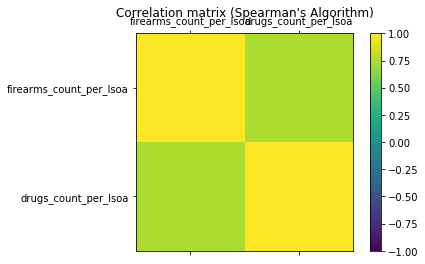

In [17]:
# Visualizing correlation matrix on a chart

fig = plt.figure(111)

# Setting the axes to display the chart
ax = fig.add_subplot(111)

# Setting all necessary parameters of the axes
ax.set_title("Correlation matrix (Spearman's Algorithm)")
ax.set_xticklabels(["","firearms_count_per_lsoa", "drugs_count_per_lsoa"])
ax.set_yticklabels(["","firearms_count_per_lsoa", "drugs_count_per_lsoa"])
cax = ax.matshow(correlation_matrix, vmax=1, vmin=-1)
fig.colorbar(cax)
plt.show()

<pre>
As we can see that correlation between the two columns as per Spearman's correlation method is very strong, let us now check the correlation again using Pearson's Algorithm
</pre>

In [18]:
# Calculating the correlation matrix using Pearson's Algorithm and visualizing the matrix

correlation = Correlation.corr(vector_df, "vector", method="pearson")

correlation = correlation.collect()[0][0]
correlation_matrix = correlation.toArray().tolist()

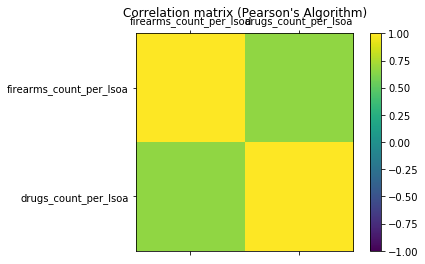

In [19]:
# Visualizing correlation matrix on a chart

fig = plt.figure(111)

# Setting the axes to display the chart
ax = fig.add_subplot(111)

# Setting all necessary parameters of the axes
ax.set_title("Correlation matrix (Pearson's Algorithm)")
ax.set_xticklabels(["","firearms_count_per_lsoa", "drugs_count_per_lsoa"])
ax.set_yticklabels(["","firearms_count_per_lsoa", "drugs_count_per_lsoa"])
cax = ax.matshow(correlation_matrix, vmax=1, vmin=-1)
fig.colorbar(cax)
plt.show()

<pre>
So, as we can see there is strong correlation between the two columns as per Pearson's Algorithm as well. So as per our analysis, <b>we can deduce that the cases related to firearms are strongly related to Drugs offences.</b>

-----------------------------------------------------------------------------------------------------------

With all the claims analyzed, lets check some of the advantages and disadvantages of the methods and tools we have used to prove/analyze the claims and at the end of the report, References are attached as well.
</pre>

<b> Advantages: </b>
- We have used static schema to make the read performance better for CSV files.
- Using function to do repetitive tasks makes code reusable and maintainable.
- Docstring is given in each function which documents each function properly so whenever it is to be used again by someone else also then the new developer knows the importance and use of the function
- Correlation method is a powerful tool through which association can be found between the columns

<b> Disadvantages: </b>
- To use static schema, schema have to be known before hand other wise it may give exception or in worst case maybe end up reading data in corrupted format.
- Correlation can only find the relation between the two columns but cannot tell if one column is causing the other column to happen, for that series of experiments are needed to be performed.
- As we are only having one program file, use of functional program might not be that important, but on corporate level with mutiple scripts, reusable code would be more beneficial.

### References:
<pre>

[1] Crimes dataset: https://data.police.uk/data/
[2] Location Anonymization: https://data.police.uk/about/#location-anonymisation
[3] Postal Codes dataset: https://www.freemaptools.com/download-uk-postcode-lat-lng.htm
[4] Correlation in Spark: https://spark.apache.org/docs/2.2.0/ml-statistics.html#correlation
[5] Correlation importance: https://www.psychologydiscussion.net/educational-psychology/statistics/correlation-definitions-types-and-importance-statistics/2788
[6] Spark Core Documentation: https://spark.apache.org/docs/latest/sql-programming-guide.html
[7] Benefits of functional programming: https://julien.danjou.info/python-and-functional-programming/
[8] Functional Programming in Python: https://stackabuse.com/functional-programming-in-python/
[9] Correlation uses: http://archive.dimacs.rutgers.edu/dci/2006/Lecture13_Correlation.pdf
</pre>